In [5]:
import numpy as np
import pandas as pd
import PIL.Image as Image
import matplotlib.pyplot as plt

# Process data

In [6]:
IMAGE_SIZE = (28, 28)

# Import data
data = pd.read_csv(r"../digit-recognizer/train.csv")
data_test = pd.read_csv(r"../digit-recognizer/test.csv")

# Get labels and image array from data
labels : np.ndarray = data.values[:30000, 0]
images : np.ndarray = data.values[:30000, 1:].astype('uint8')

images_test : np.ndarray = data_test.values.astype('uint8')

labels_test_with_label = data.values[30000:, 0]
images_test_with_label = data.values[30000:, 1:].astype('uint8')


# Reference for backpropagation (from 3b1b neural network video)

![title](image.png)

# <center> MODELS </center>

In [7]:
# I'll try to make it more modular later
class LinearLayer:
    def __init__(self, input, output):
        self.w_input = np.random.normal(size=(input, output))
        self.b_input = np.zeros(output)

In [8]:
class Model:
    def __init__(self, input, hidden, output, lr):
        # Initialize weight and bias
        self.w_input = np.random.normal(size=(input, hidden))
        self.b_input = np.zeros(hidden)
        self.w_hidden = np.random.normal(size=(hidden, output))
        self.b_hidden = np.zeros(output)
        
        self.lr = lr
        self.costs = []

    def _sigmoid(self, x, derive=False):
        if derive:
            return self._sigmoid(x) * (1-self._sigmoid(x))
        return 1 / (1 + np.exp(-x))

    def _softmax(self, x : np.ndarray):
        exps = np.exp(x - x.max())
        return exps / np.sum(exps) 

    def plot(self):
        plt.plot(self.costs, 'bo')
        plt.xlabel("Data")
        plt.ylabel("Costs")
        plt.show()



class Softmax(Model):
    def __init__(self, input, hidden, output, lr):
        super().__init__(input, hidden, output, lr)
    
    def forward(self, x):
        x = np.dot(x, self.w_input)
        # x += self.b_input
        # x = self._sigmoid(x)
        x = np.dot(x, self.w_hidden)
        x = np.clip(x, 1e-7, 1e7)
        # x += self.b_hidden
        x = self._softmax(x)
        
        return x

    def train(self, input: np.ndarray, pred: np.ndarray, label: np.ndarray, debug=False):
        # ============================================
        # Softmax with Cross Entropy Loss
        # cost = -ln(pred[argmax(label)]) {natural log of correct prediction}
        # d_cost/d_pred = -1 / pred[argmax(label)] {1 value}
        
        # pred = softmax(out)
        # d_pred/d_out:
        #   i = j -> d_pred = pred[J] * (1-pred[i])
        #   i != j -> d_pred = -pred[j] * pred[i]
        #   where j is the correct label idx 
        
        correct = label.argmax()
        d_pred = []
        for i in range(len(pred)):
            if i == correct:
                d_pred.append(pred[correct] * (1-pred[i]))
            else:
                d_pred.append(-pred[correct] * pred[i])

        d_cost = -1 / pred[correct] # 1. Only the correct prediction affects the cost
        d_pred = np.array(d_pred) # (10, ). Imagine ten weights connected to the correct prediction to calculate the softmax
        d_out = self.w_hidden # (16, 10)
        d_hidden = input # (784, )

        step = np.outer(d_hidden, np.dot(d_out, d_pred)) * d_cost * self.lr
        # print(d_cost, d_pred.shape, d_out.shape, d_hidden.shape)
        self.w_hidden -= np.outer(np.dot(input, self.w_input), d_pred * d_cost) * self.lr
        self.w_input -= step
        
        # Debug
        if (debug):
            print("Cost: ", -np.log(pred[correct]))
            # print("Step: ", step)
             # print("d_pred: ", d_pred)
            # print("d_cost: ", d_cost)
            
        # ============================================



class Sigmoid(Model):
    def __init__(self, input, hidden, output, lr):
        super().__init__(input, hidden, output, lr)

    def forward(self, x):
        x = np.dot(x, self.w_input)
        # x += self.b_input
        x = np.dot(x, self.w_hidden)
        # x += self.b_hidden
        x = self._sigmoid(x)
        
        return x

    def train(self, input: np.ndarray, pred: np.ndarray, label: np.ndarray, debug=False):
        # ============================================
        # # Sigmoid with MSELoss (Mean Squared Error)
        # cost = 1/len(pred) * np.sum(pred-label)**2
        # d_cost/d_pred = 2/len(pred) * (pred-label)
        # d_cost = 10 (1 for each prediction?)
        
        # pred = _sigmoid(out) {a(L)}
        # d_pred/d_out = self._sigmoid(out, derive=True)
        # d_pred = 10 (1 for each output?)     
        
        # out = dot(dot(input, w_input), w_hidden)
        # d_out/d_hidden = w_hidden (how much does hidden layer affects output, which depends on hidden layer's weight)
        # d_out = hidden_size * output_size {(16, 10) matrix}

        # hidden = dot(input, w_input)
        # d_hidden/d_w_input = input (how much does weight affects hidden values, which depends on input)

        # Gradient Descent
        d_cost = 2/len(pred) * (pred-label) # (10, )
        d_pred = self._sigmoid(np.dot(np.dot(input, self.w_input), self.w_hidden), derive=True) # (10, )
        d_out = self.w_hidden # (16, 10)
        d_hidden = input # (784, )

        # print(np.dot(input, self.w_input).shape)
        self.w_hidden -= np.outer(np.dot(input, self.w_input), d_pred * d_cost) * self.lr
        self.w_input -= np.outer(d_hidden, np.dot(d_out, d_pred * d_cost)) * self.lr
        
        self.costs.append(np.sum(pred-label)**2/len(pred))

        # Debug
        if (debug):
            print("Cost: ", np.sum(pred-label)**2/len(pred))
            # print("Step: ", step)
            # print("d_pred: ", d_pred)
            # print("d_cost: ", d_cost)
            
        # ============================================

# Test

Data 2000: Wrong = 1697, Accuracy: 15.107553776888452%
Data 4000: Wrong = 3356, Accuracy: 16.07901975493874%
Data 6000: Wrong = 4978, Accuracy: 17.01950325054176%
Data 8000: Wrong = 6549, Accuracy: 18.127265908238527%
Data 10000: Wrong = 8060, Accuracy: 19.3919391939194%
Data 12000: Wrong = 9542, Accuracy: 20.476706392199347%
Data 14000: Wrong = 10955, Accuracy: 21.744410315022506%
Data 16000: Wrong = 12346, Accuracy: 22.83267704231514%
Data 18000: Wrong = 13657, Accuracy: 24.123562420134448%
Data 20000: Wrong = 14925, Accuracy: 25.371268563428174%
Data 22000: Wrong = 16168, Accuracy: 26.50575026137551%
Data 24000: Wrong = 17373, Accuracy: 27.609483728488684%
Data 26000: Wrong = 18560, Accuracy: 28.61263894765183%
Data 28000: Wrong = 19728, Accuracy: 29.540340726454517%
Data 30000: Wrong = 20841, Accuracy: 30.527684256141868%


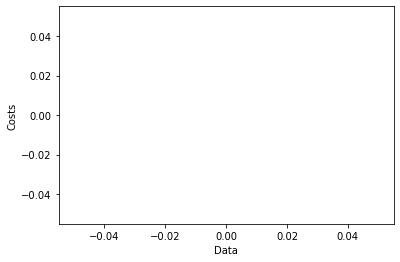

Epoch: 1 --> Wrong: 20841, Accuracy: 30.53%

Data 2000: Wrong = 1087, Accuracy: 45.622811405702855%
Data 4000: Wrong = 2105, Accuracy: 47.361840460115026%
Data 6000: Wrong = 3124, Accuracy: 47.92465410901817%
Data 8000: Wrong = 4139, Accuracy: 48.2560320040005%
Data 10000: Wrong = 5099, Accuracy: 49.00490049004901%
Data 12000: Wrong = 6091, Accuracy: 49.23743645303775%
Data 14000: Wrong = 7035, Accuracy: 49.746410457889844%
Data 16000: Wrong = 7966, Accuracy: 50.209388086755425%
Data 18000: Wrong = 8851, Accuracy: 50.82504583587977%
Data 20000: Wrong = 9701, Accuracy: 51.49257462873143%
Data 22000: Wrong = 10595, Accuracy: 51.83871994181553%
Data 24000: Wrong = 11452, Accuracy: 52.281345056044%
Data 26000: Wrong = 12306, Accuracy: 52.66741028501096%
Data 28000: Wrong = 13168, Accuracy: 52.96974891960427%
Data 30000: Wrong = 14025, Accuracy: 53.24844161472049%


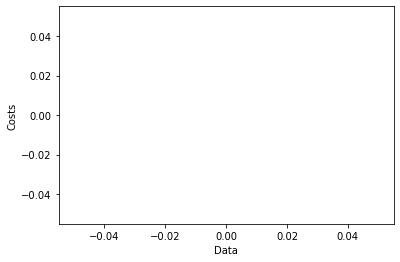

Epoch: 2 --> Wrong: 14025, Accuracy: 53.25%

Data 2000: Wrong = 826, Accuracy: 58.67933966983492%
Data 4000: Wrong = 1579, Accuracy: 60.515128782195546%
Data 6000: Wrong = 2361, Accuracy: 60.643440573428904%
Data 8000: Wrong = 3140, Accuracy: 60.74509313664208%
Data 10000: Wrong = 3891, Accuracy: 61.08610861086108%
Data 12000: Wrong = 4686, Accuracy: 60.946745562130175%
Data 14000: Wrong = 5418, Accuracy: 61.29723551682263%
Data 16000: Wrong = 6143, Accuracy: 61.60385024064004%
Data 18000: Wrong = 6878, Accuracy: 61.786765931440634%
Data 20000: Wrong = 7576, Accuracy: 62.11810590529526%
Data 22000: Wrong = 8316, Accuracy: 62.19828174007909%
Data 24000: Wrong = 9026, Accuracy: 62.39009958748281%
Data 26000: Wrong = 9723, Accuracy: 62.6024077849148%
Data 28000: Wrong = 10456, Accuracy: 62.655809136040574%
Data 30000: Wrong = 11182, Accuracy: 62.72542418080603%


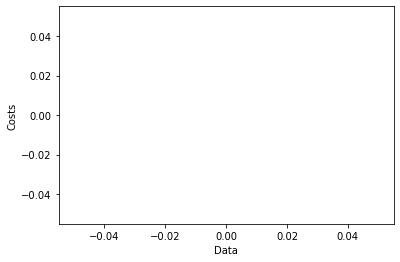

Epoch: 3 --> Wrong: 11182, Accuracy: 62.72666666666667%

Data 2000: Wrong = 662, Accuracy: 66.88344172086043%
Data 4000: Wrong = 1327, Accuracy: 66.81670417604401%
Data 6000: Wrong = 2000, Accuracy: 66.66111018503084%
Data 8000: Wrong = 2672, Accuracy: 66.59582447805975%
Data 10000: Wrong = 3317, Accuracy: 66.82668266826683%
Data 12000: Wrong = 3999, Accuracy: 66.67222268522377%
Data 14000: Wrong = 4635, Accuracy: 66.89049217801272%
Data 16000: Wrong = 5268, Accuracy: 67.07294205887868%
Data 18000: Wrong = 5912, Accuracy: 67.15373076282016%
Data 20000: Wrong = 6524, Accuracy: 67.37836891844591%
Data 22000: Wrong = 7166, Accuracy: 67.42579208145824%
Data 24000: Wrong = 7794, Accuracy: 67.52364681861744%
Data 26000: Wrong = 8407, Accuracy: 67.66414092849726%
Data 28000: Wrong = 9053, Accuracy: 67.66670238222794%
Data 30000: Wrong = 9705, Accuracy: 67.64892163072102%


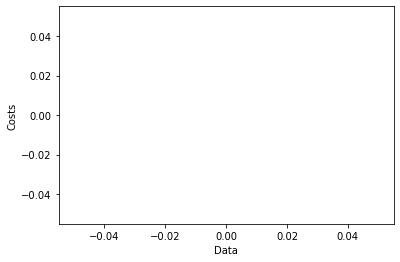

Epoch: 4 --> Wrong: 9705, Accuracy: 67.65%

Data 2000: Wrong = 591, Accuracy: 70.43521760880441%
Data 4000: Wrong = 1169, Accuracy: 70.76769192298075%
Data 6000: Wrong = 1764, Accuracy: 70.5950991831972%
Data 8000: Wrong = 2352, Accuracy: 70.59632454056757%
Data 10000: Wrong = 2929, Accuracy: 70.7070707070707%
Data 12000: Wrong = 3543, Accuracy: 70.47253937828152%
Data 14000: Wrong = 4110, Accuracy: 70.64076005428959%
Data 16000: Wrong = 4680, Accuracy: 70.74817176073505%
Data 18000: Wrong = 5269, Accuracy: 70.72615145285849%
Data 20000: Wrong = 5818, Accuracy: 70.90854542727136%
Data 22000: Wrong = 6400, Accuracy: 70.90776853493341%
Data 24000: Wrong = 6964, Accuracy: 70.9821242551773%
Data 26000: Wrong = 7512, Accuracy: 71.10658102234702%
Data 28000: Wrong = 8107, Accuracy: 71.04539447837423%
Data 30000: Wrong = 8705, Accuracy: 70.98236607886929%


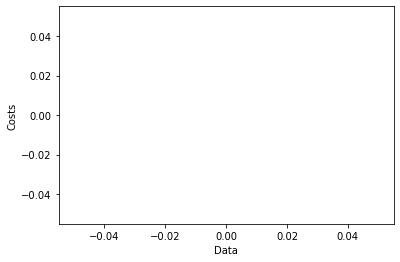

Epoch: 5 --> Wrong: 8705, Accuracy: 70.98333333333333%

Data 2000: Wrong = 534, Accuracy: 73.28664332166083%
Data 4000: Wrong = 1059, Accuracy: 73.51837959489873%
Data 6000: Wrong = 1600, Accuracy: 73.32888814802467%
Data 8000: Wrong = 2146, Accuracy: 73.17164645580698%
Data 10000: Wrong = 2675, Accuracy: 73.24732473247325%
Data 12000: Wrong = 3234, Accuracy: 73.0477539794983%
Data 14000: Wrong = 3763, Accuracy: 73.11950853632402%
Data 16000: Wrong = 4282, Accuracy: 73.23582723920245%
Data 18000: Wrong = 4837, Accuracy: 73.12628479359964%
Data 20000: Wrong = 5347, Accuracy: 73.26366318315915%
Data 22000: Wrong = 5885, Accuracy: 73.24878403563798%
Data 24000: Wrong = 6404, Accuracy: 73.31555481478395%
Data 26000: Wrong = 6920, Accuracy: 73.38359167660295%
Data 28000: Wrong = 7471, Accuracy: 73.31690417514912%
Data 30000: Wrong = 8030, Accuracy: 73.23244108136939%


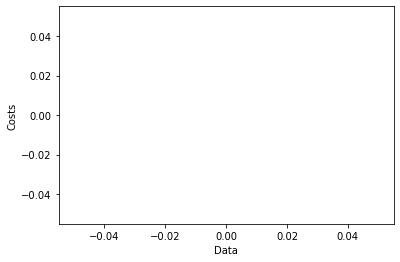

Epoch: 6 --> Wrong: 8030, Accuracy: 73.23333333333333%

Data 2000: Wrong = 487, Accuracy: 75.63781890945472%
Data 4000: Wrong = 980, Accuracy: 75.4938734683671%
Data 6000: Wrong = 1478, Accuracy: 75.36256042673779%
Data 8000: Wrong = 1999, Accuracy: 75.0093761720215%
Data 10000: Wrong = 2492, Accuracy: 75.07750775077508%
Data 12000: Wrong = 3011, Accuracy: 74.9062421868489%
Data 14000: Wrong = 3519, Accuracy: 74.86249017786986%
Data 16000: Wrong = 3994, Accuracy: 75.03593974623413%
Data 18000: Wrong = 4508, Accuracy: 74.9541641202289%
Data 20000: Wrong = 4986, Accuracy: 75.06875343767189%
Data 22000: Wrong = 5494, Accuracy: 75.0261375517069%
Data 24000: Wrong = 5978, Accuracy: 75.09062877619901%
Data 26000: Wrong = 6465, Accuracy: 75.13365898688411%
Data 28000: Wrong = 6979, Accuracy: 75.07410978963534%
Data 30000: Wrong = 7508, Accuracy: 74.97249908330278%


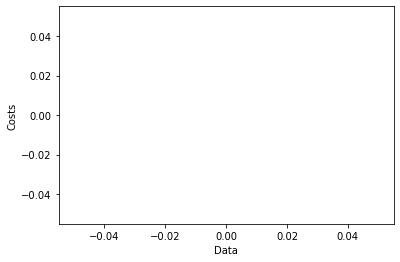

Epoch: 7 --> Wrong: 7508, Accuracy: 74.97333333333333%

Data 2000: Wrong = 461, Accuracy: 76.93846923461732%
Data 4000: Wrong = 935, Accuracy: 76.61915478869717%
Data 6000: Wrong = 1405, Accuracy: 76.57942990498417%
Data 8000: Wrong = 1894, Accuracy: 76.32204025503188%
Data 10000: Wrong = 2355, Accuracy: 76.44764476447645%
Data 12000: Wrong = 2844, Accuracy: 76.29802483540294%
Data 14000: Wrong = 3323, Accuracy: 76.26259018501321%
Data 16000: Wrong = 3771, Accuracy: 76.42977686105382%
Data 18000: Wrong = 4263, Accuracy: 76.31535085282516%
Data 20000: Wrong = 4721, Accuracy: 76.39381969098454%
Data 22000: Wrong = 5191, Accuracy: 76.40347288513115%
Data 24000: Wrong = 5650, Accuracy: 76.45735238968291%
Data 26000: Wrong = 6112, Accuracy: 76.49140351551983%
Data 28000: Wrong = 6598, Accuracy: 76.43487267402408%
Data 30000: Wrong = 7096, Accuracy: 76.34587819593986%


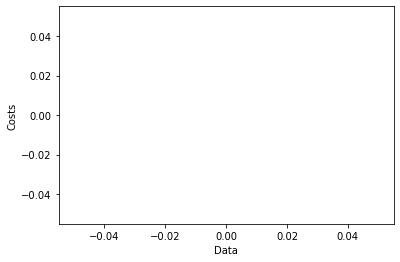

Epoch: 8 --> Wrong: 7096, Accuracy: 76.34666666666666%

Data 2000: Wrong = 447, Accuracy: 77.63881940970485%
Data 4000: Wrong = 894, Accuracy: 77.64441110277569%
Data 6000: Wrong = 1337, Accuracy: 77.71295215869311%
Data 8000: Wrong = 1794, Accuracy: 77.57219652456557%
Data 10000: Wrong = 2239, Accuracy: 77.60776077607761%
Data 12000: Wrong = 2704, Accuracy: 77.46478873239437%
Data 14000: Wrong = 3161, Accuracy: 77.41981570112151%
Data 16000: Wrong = 3590, Accuracy: 77.56109756859803%
Data 18000: Wrong = 4053, Accuracy: 77.48208233790766%
Data 20000: Wrong = 4490, Accuracy: 77.54887744387219%
Data 22000: Wrong = 4941, Accuracy: 77.5398881767353%
Data 24000: Wrong = 5382, Accuracy: 77.57406558606608%
Data 26000: Wrong = 5819, Accuracy: 77.61836993730529%
Data 28000: Wrong = 6277, Accuracy: 77.58134219079253%
Data 30000: Wrong = 6761, Accuracy: 77.46258208606955%


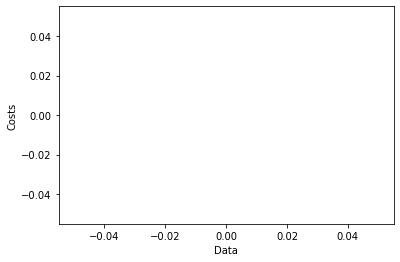

Epoch: 9 --> Wrong: 6761, Accuracy: 77.46333333333334%

Data 2000: Wrong = 432, Accuracy: 78.38919459729865%
Data 4000: Wrong = 859, Accuracy: 78.51962990747687%
Data 6000: Wrong = 1284, Accuracy: 78.5964327387898%
Data 8000: Wrong = 1724, Accuracy: 78.44730591323915%
Data 10000: Wrong = 2141, Accuracy: 78.58785878587858%
Data 12000: Wrong = 2583, Accuracy: 78.47320610050838%
Data 14000: Wrong = 3023, Accuracy: 78.40560040002858%
Data 16000: Wrong = 3437, Accuracy: 78.51740733795862%
Data 18000: Wrong = 3886, Accuracy: 78.40991166175898%
Data 20000: Wrong = 4304, Accuracy: 78.47892394619731%
Data 22000: Wrong = 4738, Accuracy: 78.46265739351789%
Data 24000: Wrong = 5162, Accuracy: 78.4907704487687%
Data 26000: Wrong = 5586, Accuracy: 78.51455825224048%
Data 28000: Wrong = 6029, Accuracy: 78.46708811028965%
Data 30000: Wrong = 6486, Accuracy: 78.3792793093103%


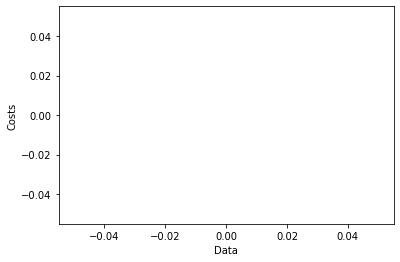

Epoch: 10 --> Wrong: 6486, Accuracy: 78.38%

Test result: 78.64166666666667% accuracy. 2563 images predicted wrong


In [11]:
EPOCH = 10
LEARNING_RATE = 0.00001

model = Softmax(IMAGE_SIZE[0]*IMAGE_SIZE[1], 256, 10, LEARNING_RATE)
# model = Sigmoid(IMAGE_SIZE[0]*IMAGE_SIZE[1], 512, 10, LEARNING_RATE)

# print(np.array([[1, 2, 3, 4], [1, 2, 3, 4], [1, 2, 3, 4]]) * np.array([2, 2, 3, 3]))

for i in range(EPOCH):
    wrong = 0
    for j, d in enumerate(images):
        # High input breaks the neural network
        # Problem such as NaN, inf, etc, because e sucks
        d = d / 255
        
        pred = model.forward(d)
        
        # 0 will also break log e, because e sucks
        # Clip pred so the value only ranges around 1e-7 and 1
        pred = np.clip(pred, 1e-7, 1)

        if (np.argmax(pred) != labels[j]):
            wrong += 1
            
        label = np.zeros(10)
        label[labels[j]] = 1
        model.train(d, pred, label)

        # print(pred)

        if ((j+1) % 2000 == 0):
            print(f"Data {j+1}: Wrong = {wrong}, Accuracy: {100-wrong/j*100}%")

    model.plot()
    print(f"Epoch: {i+1} --> Wrong: {wrong}, Accuracy: {100-wrong / labels.size * 100}%\n")    

wrong = 0
# for i in range(100):
#     res = np.argmax(model.forward(images_test[i] / 255))
#     img = Image.fromarray(images_test[i].reshape(IMAGE_SIZE))
#     print(f"Image {i+1}: {res}")
#     img.save(f"./test_softmax_scratch/{str(i+1)}_ans={res}.jpg")

for i, image in enumerate(images_test_with_label):
    pred = model.forward(image)
    wrong += (pred.argmax() != labels_test_with_label[i])

print(f"Test result: {100 - (wrong / labels_test_with_label.size * 100)}% accuracy. {wrong} images predicted wrong")

In [ ]:
testing = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [0, 1, 1],
    [0, 0, 1],
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0]
])

label = np.array(
    [1, 1, 1, 1, 0, 1, 1]
)

model = Sigmoid(3, 1024, 1, LEARNING_RATE)
for e in range(1000000):
    results = []
    for i, d in enumerate(testing):
        res = float(model.forward(d))
        
        results.append(res)
        model.train(d, np.array([res]), np.array(label[i]))
    
    if ((e+1) % 100 == 0):
        print(f"Epoch {e+1}: {results}")

Epoch 100: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588013, 0.999999999999986]
Epoch 200: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588013, 0.999999999999986]
Epoch 300: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588016, 0.999999999999986]
Epoch 400: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588016, 0.999999999999986]
Epoch 500: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588016, 0.999999999999986]
Epoch 600: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588016, 0.999999999999986]
Epoch 700: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588018, 0.999999999999986]
Epoch 800: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588018, 0.999999999999986]
Epoch 900: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588018, 0.999999999999986]
Epoch 1000: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588018, 0.999999999999986]
Epoch 1100: [1.0, 1.0, 1.0, 1.0, 0.5, 0.9999976039588018, 0.999999999999986]
Epoch 1200: [1.0, 1.0, 1.0, 1.0, 0.5, 0.999997603958802, 0.999999999999986]
Epoch 1300: [1.0, 1.0, 1.0, 1.0, 0.5, 0.999997603958802, 0.999999999999986]
Epoch 1400

KeyboardInterrupt: 